### This code only work with models saved from TensorFlow v1

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import galaxies_datTrue as galax
from matplotlib import pyplot as plt
import data_util as data_util
import PreprocessImagesforInference as prep
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Instructions for updating:
non-resource variables are not supported in the long term


### Prepare dataset with batch size of 16

In [2]:
ds = galax.get_data_test()
ds = ds.map(prep.map_fn,num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(16, drop_remainder=False)
ds = prep.pad_to_batch(ds, 16)
#get images and labels from ds
images, labels = tf.data.make_one_shot_iterator(ds).get_next()

### Open model

In [3]:
#set the path were the model is stored
hub_path = '/home/pedri0/Documents/GitHub/Modified-SimCLR/savedModels/astropre100epochsfine90/finetunas/hub/141358/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=images, signature="default", as_dict=True)
logits_t = key['logits_sup'][:, :]
print(key)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
{'block_group4': <tf.Tensor 'module_apply_default/base_model/block_group4:0' shape=(16, 11, 11, 2048) dtype=float32>, 'block_group3': <tf.Tensor 'module_apply_default/base_model/block_group3:0' shape=(16, 21, 21, 1024) dtype=float32>, 'block_group2': <tf.Tensor 'module_apply_default/base_model/block_group2:0' shape=(16, 42, 42, 512) dtype=float32>, 'initial_conv': <tf.Tensor 'module_apply_default/base_model/initial_conv:0' shape=(16, 165, 165, 64) dtype=float32>, 'default': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(16, 2048) dtype=float32>, 'final_avg_pool': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(16, 2048) dtype=float32>, 'block_group1': <tf.Tensor 'module_apply_default/base_model/block_group1:0' shape=(16, 83, 83, 256) dtype=float32>, 'logits_sup': <tf.Tensor 'module_apply_default/head_supervised/linear_layer/linear_layer_out:0' shape=(16, 5

### Inference with given images from galaxies_datTrue method get_data_test()

In [4]:
#if you want to change the images please modify the get_data_test() method in galaxies_datTrue.py
#set lists to store predicted clases and real clases
predicted = []
real_label = []
#do inference
with tf.compat.v1.Session() as ses:
    ses.run(tf.global_variables_initializer())
    try:
        while True:
            image, label, logits = ses.run((images, labels, logits_t))
            pred = logits.argmax(-1)
            predicted.append(pred)
            for i in range(16):
                if np.sum(label[i]!=0):
                    real_label.append(label[i])
                else:
                    continue
        
    except tf.errors.OutOfRangeError:
        pass

### 'Process' the results

In [5]:
#convert lists to numpy arrays        
predicted = np.array(predicted)
predicted = predicted.flatten()

real_label = np.array(real_label)
#one hot for predicted array
with tf.compat.v1.Session() as ses:
    prediction_one_hot = ses.run((tf.one_hot(predicted,5)))

### Get Acurracy of the model

In [6]:
#count how many correct predictions
count = 0
for i in range(real_label.shape[0]):
    is_true = np.array_equal(prediction_one_hot[i], real_label[i])
    if is_true:
        count += 1
print('Accuracy : {} %'.format((count*100/real_label.shape[0])))

Accuracy : 68.05382506852729 %


### Showing the last images

In [7]:
#function to convert float32 image into uint8 image
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [8]:
#convert each image
img = []
for i in range(9):
    im = convert(image[i])
    img.append(im)

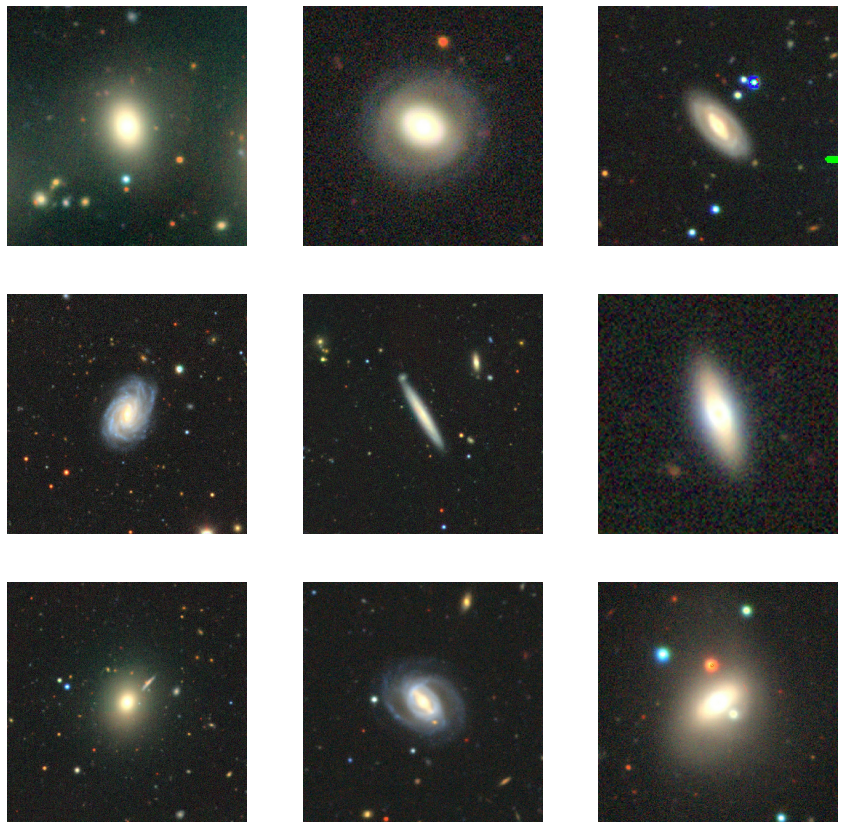

In [9]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i])
    plt.axis("off")